In [1]:
%matplotlib inline
import os
import cv2
import random
import itertools
import colorsys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, lines
from matplotlib.patches import Polygon
from skimage.measure import find_contours
from pycocotools.coco import COCO

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(12, 12), 
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None, 
                      text_size=10, text_background=None, output_path=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [num_instances, [height, width] ]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """

    fig, ax = plt.subplots(1, figsize=figsize)

    # Generate random colors for bbox and text
    if colors == 'random' or colors is None:
        colors = [[]] + random_colors(len(class_names))     

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(boxes.shape[0]):
        color = colors[class_ids[i]]
        

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue

        x1, y1, x2, y2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2, y2, linewidth=1,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        
        if text_background:
            ax.text(x1+5, y1 - 10, caption, color=color, size=text_size, bbox=dict(facecolor=text_background, edgecolor=text_background, alpha=0.5))
            #ax.text(x1+5, y1 - 10, caption, color=color, size=text_size, backgroundcolor=text_background)
        else:
            ax.text(x1+5, y1 - 10, caption, color=color, size=text_size)
            
        # Mask
        mask = masks[i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    
    if output_path:
        fig.savefig(output_path)
        plt.close(1)
    else:
        plt.show()
        plt.close(1)
        
def show_annotation_result(img, bbox_result=None, segm_result=None, labels=None, class_names=None, colors='random',
                           output_path=None, with_mask=False, show_mask=False, save_boxes=False):
    
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if with_mask:
        segms = list(itertools.chain(*segm_result))

    bboxes = np.vstack(bbox_result)
    masks = []
    #labels = [np.full(bbox.shape[0], i, dtype=np.int32)
    #            for i, bbox in enumerate(bbox_result)]
    #labels = np.concatenate(labels)
    
    #print(segms[0])
    if with_mask:
        for i in range(len(segm_result)):
            #color_mask = np.random.randint(0, 256, (1, 3), dtype=np.uint8)
            #mask = maskUtils.decode(segms[i]).astype(np.bool)
            mask = coco.annToMask(segm_result[i])
            masks.append(mask)
    else:
        masks = [np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)] * bboxes.shape[0]  # create empty masks 
    
    display_instances(img, boxes=bboxes[:, :4], masks=masks, 
                      class_ids=labels, class_names=np.asarray(class_names),
                      scores=None, title="",
                      figsize=(12, 12), show_mask=show_mask, show_bbox=True,
                      colors=fixed_color_map, captions=None, text_size=10, text_background=None, output_path=output_path)
    
def show_one_result(imgId, data_prefix, coco=None, colors=None, class_names=None):
    if class_names == None:
        cats = coco.loadCats(coco.getCatIds())
        class_names = [""] + [cat['name'] for cat in cats]
    
    selected_anns = coco.getAnnIds(imgIds=imgId)
    img_path = coco.loadImgs(imgId)[0]["file_name"]
    img_path = os.path.join(data_prefix, img_path)
    label_result = []
    bbox_result = []
    segm_result = []
    for ann in coco.loadAnns(selected_anns):
        label_result.append(ann["category_id"])
        bbox_result.append(ann["bbox"])
        segm_result.append(ann)
        
    show_annotation_result(img_path, bbox_result=bbox_result, segm_result=segm_result, labels=label_result, class_names=class_names, colors=colors,
                           output_path=None, with_mask=True, show_mask=False, save_boxes=False)


def show_bbox_and_images(selected_categories=[], thickness=2, figsize=(12,12), image_only=False):
    # get all images containing given categories, select one randomly
    catIds = coco.getCatIds(catNms=selected_categories)
    imgIds = coco.getImgIds(catIds=catIds)
    #print("Imgs with all those categories", imgIds)

    # random select one image
    random_idx = random.randint(0,len(imgIds)-1)
    print("The image ID randomly selected is {}".format(imgIds[random_idx]))
    selected_anns = coco.getAnnIds(imgIds = imgIds[random_idx])
    print("Selected annotation ids are", selected_anns)

    img_filename = coco.loadImgs(imgIds[random_idx])[0]["file_name"]
    img = cv2.imread(os.path.join(data_dir, img_filename))
    
    if not image_only:
        # show bbox
        for a in coco.loadAnns(selected_anns):
            (x, y, w, h) = a['bbox']
            cv2.rectangle(img, (x,y), (x+w,y+h), (255,255,0), thickness)
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


In [2]:
# Here we use fixed_color_map, leave colors=None, then it will generate random color for each class
fixed_color_map = [(),
        (0.0, 0.0, 1.0),
        (1.0, 0.4, 0.0),
        (0.9, 0.0, 0.0),
        (0.1, 0.9, 0.1),
        (0.2, 0.9, 1.0)]

# can not show Chinese character in Jinnan Dataset
show_class_names = [" ", "metal_lighter", "lighter", "knife", "battery", "scissor"]
    
# Please specify the COCO compatible format annotation files and data prefix
annFile="/home/robin/datatsets/xray/annotations/all_data.json"
data_dir = "/home/robin/datatsets/xray/JPEGImages"

# initialize COCO api for instance annotations
coco=COCO(annFile)

# display COCO categories
cats = coco.loadCats(coco.getCatIds())
real_class_names=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(real_class_names)))

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
COCO categories: 
铁壳打火机 黑钉打火机 刀具 电源和电池 剪刀



The image ID randomly selected is 639
Selected annotation ids are [5472, 5473, 5474, 5475, 5476]


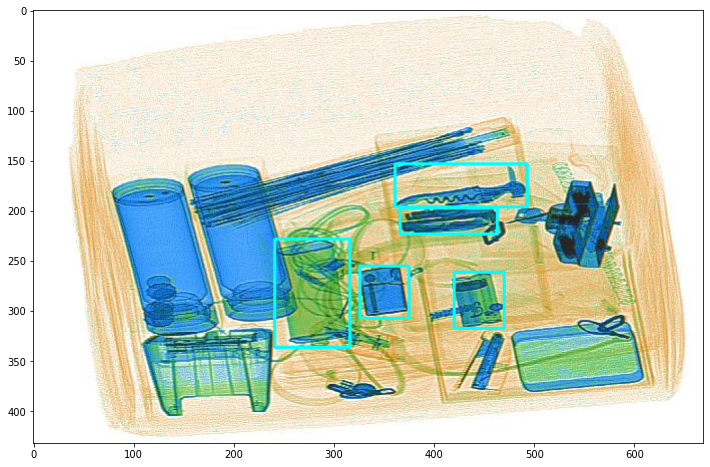

In [3]:
show_bbox_and_images(selected_categories=[''], thickness=2)

The image ID randomly selected is 611
Selected annotation ids are [5232, 5233, 5234, 5235, 5236, 5237, 5238, 5239, 5240, 5241, 5242, 5243, 5244, 5245, 5246, 5247, 5248, 5249, 5250, 5251]


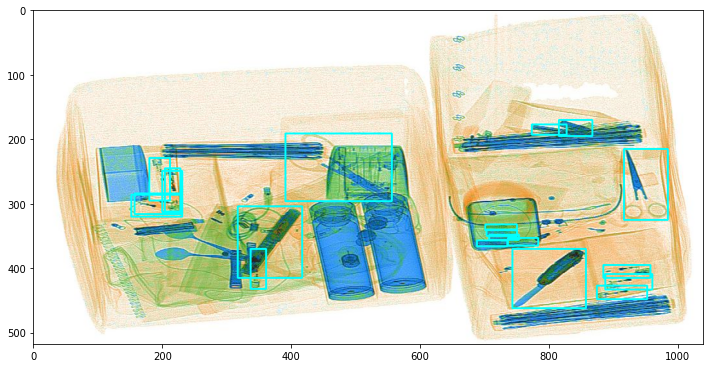

In [4]:
show_bbox_and_images(selected_categories=[''], thickness=2)

The image ID randomly selected is 1828
Selected annotation ids are [13024, 13025, 13026, 13027, 13028, 13029, 13030, 13031]


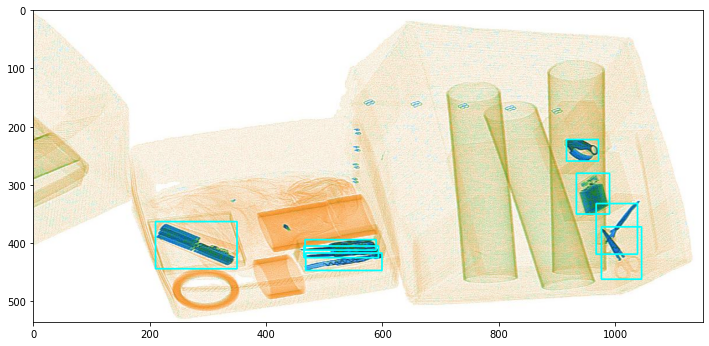

In [5]:
# if selected_categories is empty, it will try to find a image with all the cetegories
show_bbox_and_images(selected_categories=['battery'], thickness=2)

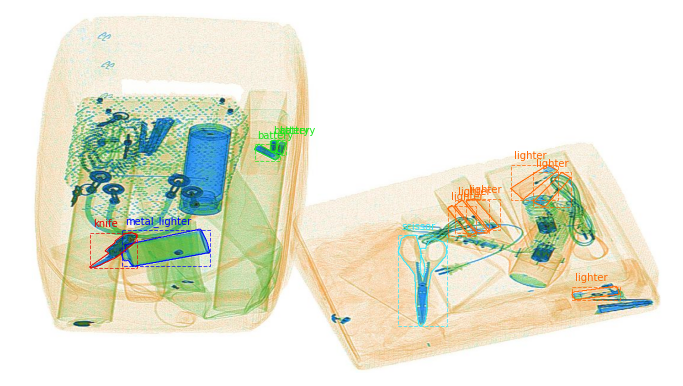

In [6]:
# Asssume we want to show image id = 21,

show_one_result(imgId=21, data_prefix=data_dir, coco=coco, colors=fixed_color_map, class_names=show_class_names)

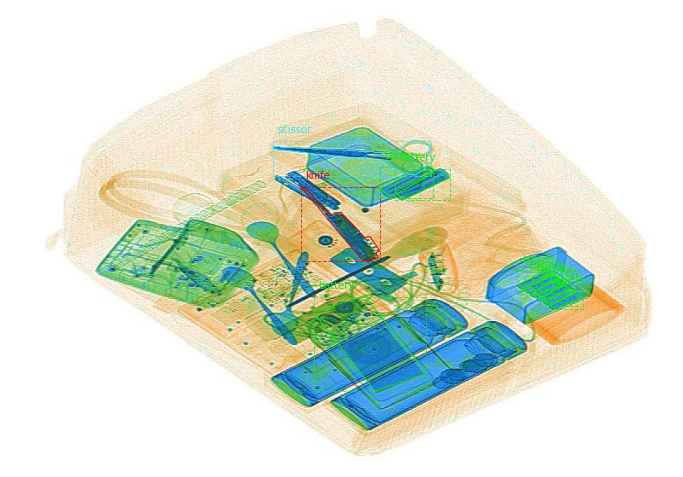

In [7]:
show_one_result(imgId=22, data_prefix=data_dir, coco=coco, colors=fixed_color_map, class_names=show_class_names)

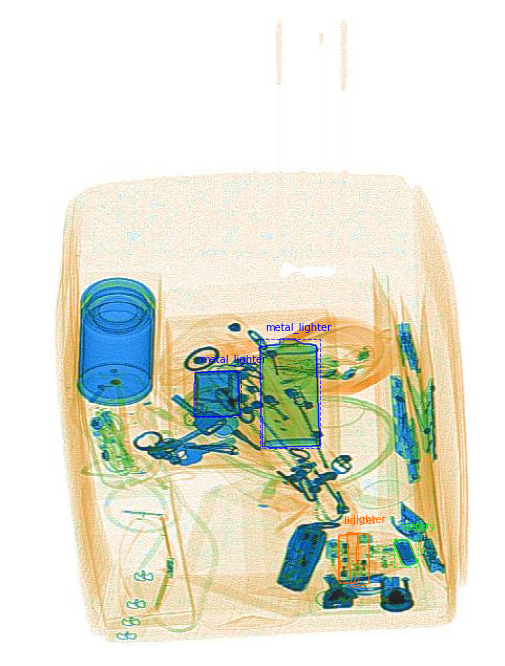

In [8]:
show_one_result(imgId=23, data_prefix=data_dir, coco=coco, colors=fixed_color_map, class_names=show_class_names)

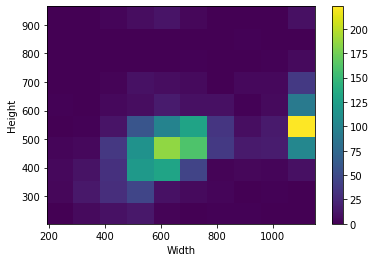

In [9]:
import matplotlib.pyplot as plt
import json
with open(annFile, "r") as f:
    data = json.load(f)
    
# Show the distribution of raw image size
x = [data["images"][i]['width'] for i in range(len(data["images"]))]
y = [data["images"][i]['height'] for i in range(len(data["images"]))]
h =plt.hist2d(x, y)
plt.colorbar(h[3])
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

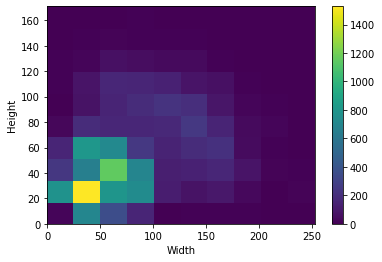

In [10]:
# Show the size distribution of bbox

x = [data["annotations"][i]["bbox"][2] for i in range(len(data["annotations"]))]
y = [data["annotations"][i]["bbox"][3] for i in range(len(data["annotations"]))]
h =plt.hist2d(x, y)
plt.colorbar(h[3])
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

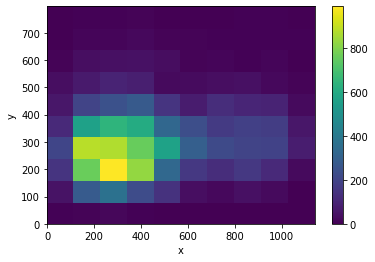

In [11]:
# Show the distribution of bbox center coordinate

# TBD change this code to relative ratio
x = [(data["annotations"][i]["bbox"][0] + data["annotations"][i]["bbox"][2]/2) for i in range(len(data["annotations"]))]
y = [(data["annotations"][i]["bbox"][1] + data["annotations"][i]["bbox"][3]/2) for i in range(len(data["annotations"]))]
h =plt.hist2d(x, y)
plt.colorbar(h[3])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [12]:
import boxx
import json
with open(annFile, "r") as fid:
    annotations = json.load(fid)
boxx.tree(annotations["categories"])

└── /: list  5
    ├── 0: dict  3
    │   ├── id: 1
    │   ├── name: 铁壳打火机
    │   └── supercategory: restricted_obj
    ├── 1: dict  3
    │   ├── id: 2
    │   ├── name: 黑钉打火机
    │   └── supercategory: restricted_obj
    ├── 2: dict  3
    │   ├── id: 3
    │   ├── name: 刀具
    │   └── supercategory: restricted_obj
    ├── 3: dict  3
    │   ├── id: 4
    │   ├── name: 电源和电池
    │   └── supercategory: restricted_obj
    └── 4: dict  3
        ├── id: 5
        ├── name: 剪刀
        └── supercategory: restricted_obj


In [13]:
boxx.tree(annotations["images"][:2])

└── /: list  2
    ├── 0: dict  8
    │   ├── coco_url: 
    │   ├── data_captured: 
    │   ├── file_name: 0.jpg
    │   ├── flickr_url: 
    │   ├── id: 0
    │   ├── height: 506
    │   ├── width: 667
    │   └── license: 1
    └── 1: dict  8
        ├── coco_url: 
        ├── data_captured: 
        ├── file_name: 1.jpg
        ├── flickr_url: 
        ├── id: 1
        ├── height: 480
        ├── width: 478
        └── license: 1


In [14]:
boxx.tree(annotations["annotations"][:1])

└── /: list  1
    └── 0: dict  8
        ├── id: 1
        ├── image_id: 0
        ├── category_id: 1
        ├── iscrowd: 0
        ├── segmentation: list  1
        │   └── 0: list  12
        │       ├── 0: 179.461
        │       ├── 1: 344.155
        │       ├── 2: 228.222
        │       ├── 3: 364.841
        │       ├── 4: 234.871
        │       ├── 5: 355.237
        │       ├── 6: 228.961
        │       ├── 7: 347.11
        │       ├── 8: 177.245
        │       ├── 9: 327.901
        │       ├── 10: 169.118
        │       └── 11: 338.245
        ├── area: 965.0
        ├── bbox: list  4
        │   ├── 0: 170
        │   ├── 1: 328
        │   ├── 2: 65
        │   └── 3: 36
        └── minAreaRect: list  4
            ├── 0: list  2
            │   ├── 0: 229
            │   └── 1: 364
            ├── 1: list  2
            │   ├── 0: 168
            │   └── 1: 339
            ├── 2: list  2
            │   ├── 0: 174
            │   └── 1: 325
            └── 3: list

In [15]:
annotations["annotations"][0]
# minAreaRect 生成最小外接矩形
# https://blog.csdn.net/lanyuelvyun/article/details/76614872

{'id': 1,
 'image_id': 0,
 'category_id': 1,
 'iscrowd': 0,
 'segmentation': [[179.461,
   344.155,
   228.222,
   364.841,
   234.871,
   355.237,
   228.961,
   347.11,
   177.245,
   327.901,
   169.118,
   338.245]],
 'area': 965.0,
 'bbox': [170, 328, 65, 36],
 'minAreaRect': [[229, 364], [168, 339], [174, 325], [235, 350]]}